In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.model_zoo as model_zoo
import math
import numpy as np
import time
import copy
from cnn3d.loss import WeightedBCELoss

from cnn3d.model3d import Cnn3d
from cnn3d.data import get_training_set, get_test_set


In [2]:
DATA_DIR = 'input/'
lungs_dir = DATA_DIR + '3Darrays_visual/'
labels_file = DATA_DIR + 'stage1_labels.csv'
batch_size = 3

trainset = get_training_set(lungs_dir, labels_file)
testset = get_test_set(lungs_dir, labels_file)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)

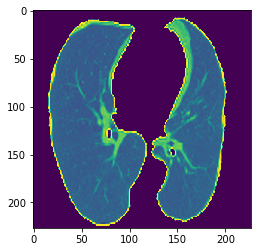

torch.Size([1, 60, 227, 227])


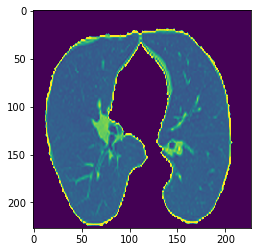

torch.Size([1, 60, 227, 227])


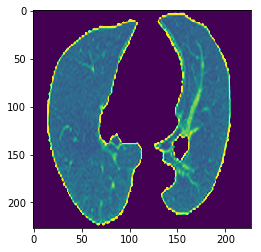

torch.Size([1, 60, 227, 227])

 0
[torch.FloatTensor of size 1x1]
 
 0
[torch.FloatTensor of size 1x1]
 
 0
[torch.FloatTensor of size 1x1]



In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(npimg)
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

for img in images:
    middle_slice = img[0][30]
    imshow(middle_slice)
    print(img.size())

print(' '.join('{label}'.format(label=labels[j]) for j in range(batch_size)))

In [4]:
from cnn3d.model3d import Cnn3d
net = Cnn3d(weight_init=1e-2).cuda()
i, data = next(enumerate(trainloader, 0))
inputs, labels = data
inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
outputs = net.features(inputs)
print(outputs.size())

RuntimeError: cuda runtime error (2) : out of memory at /b/wheel/pytorch-src/torch/lib/THC/generic/THCStorage.cu:66

In [ ]:
def train_model(model,dset_loaders, criterion, optimizer, num_epochs=25):#lr_scheduler, num_epochs=25):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if torch.cuda.is_available():
                    inputs, labels = Variable(inputs.cuda()), \
                        Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                    
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                #_, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum((outputs.data > .5) == (labels.data > .5))

            epoch_loss = running_loss / (len(dset_loaders[phase]) * batch_size)
            epoch_acc = running_corrects / (len(dset_loaders[phase]) * batch_size)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer


In [ ]:

if torch.cuda.is_available():
    net = net.cuda()

#criterion = nn.BCELoss()
criterion = WeightedBCELoss(.75)


# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(net.parameters(), lr=.001, momentum=0.9, weight_decay=1e-3)


In [ ]:
dset_loaders = { 'train': trainloader, 'val': testloader}
model_ft = train_model(net,dset_loaders, criterion, optimizer_ft,
                       num_epochs=25)